# CSII 2024 Exercise 11: Nonlinear Control Part 1
&copy; 2024 ETH Zurich, Felix Schnitzler, Jungcheng Fu, Dejan Milojevic, Paolo Petri, Joël Gmür, Niclas Scheuer, Roy Werder; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

## Description
This week's Jupyter notebook will cover Linearization and Lyapunov stability.

As usual, we start by installing the `control` module and import the required libraries.

In [83]:
import numpy as np
import control as ct
import control.flatsys as fs
import matplotlib.pyplot as plt
from cs2solutions import NLC
from typing import List, Tuple, Optional

## Example 1
You are an engineer on a racing team for Formula 1 and you are currently working on optimizing the drag force on your teams racecar. To model the vehicles behaviour you need to recall the equation for drag force that you first learned about at ETH.
$$ F_{d} = \frac{1}{2}\rho c_d A\dot{x}(t)^2 , $$ 
where $\rho$ is the density of air, $c_d$ is the drag coefficient and $A$ is the affected reference area.
We model the total force $F_{tot}$ on the vehicle as the combination of the input acceleration $u(t)$ and the drag force $F_d$:
$$ F_{tot} = m u(t) - F_d$$
In a simplified manner, we can think of $u(t)$ as the position of the gas pedal. Writing this in terms of distance $x(t)$ and its derivatives we get:
$$ m\ddot{x}(t) = -\frac{1}{2}\rho c_d A\dot{x}(t)^2 + mu(t)$$
Since we are interested in the velocity of the system, we can transform this into a first order differential equation by setting $v(t) = \dot{x}(t)$. The total system now reads:
\begin{align*}
\dot{v}(t) &= -\gamma v(t)^2 + u(t)\\
y(t) &= v(t)
\end{align*}
where $\gamma = \frac{1}{2m}\rho c_d A$ and $y(t)$ is the output of the system.


### Define the nonlinear system

You define the nonlinear system in the function `nonlinear_sys` below. The function should take the state $x$, the input $u$ and the parameters $\gamma$ as arguments and return the derivative of the state $v$ as $vdot$. A second function `nonlinear_sys_out` should take the state $v$ as the argument and return the system output $y$.

You know the following parameters to evaluate $\gamma$:

$m = 800kg$, $\rho = 1.293 \frac{kg}{m^3}$, $c_d = 1.1$, $A = 1.38m^2$

In [96]:
# Defining parameters
m = 800 # kg
rho = 1.293 # kg/m^3
c_d = 1.1 # drag coefficient
A = 1.38 # m^2

gamma = 1/(2*m) * rho * c_d * A

# Function that defines the nonlinear system 
def nonlinear_sys(t: float, v: float, u: float, params) -> float:
    """
    This can be interpreted as the first equation of the state-space equation.

    Parameters:
    - ``v`` (float): The input value.
    - ``u`` (float): The input value.

    Returns:
    - ``float``: The output value.
    """
    vdot = -gamma*v**2 + u
    return vdot

# Function that defines the nonlinear system output
def nonlinear_sys_out(t: float, v: float, u: float, params ) -> float:
    """
    This can be interpreted as the second equation of the state-space equation.

    Parameters:
    - ``v`` (float): The input value.

    Returns:
    - ``float``: The output value.
    """
    y = v
    return y

### Define the input-output system

Define the input-output system `sys` using `ct.NonlinearIOSystem()`. Additionally, simulate the input-output response of the system using `ct.input_output_response()` in response to an input $u$. We will model the input as an acceleration of 2G's or approximately $20 \frac{m}{s^2}$.

In [85]:
u = 0

def simulate_nonlinear(nonlinear_sys: callable, nonlinear_sys_out: callable, u: float, initial_v: Optional[float]) -> Tuple[np.ndarray, np.ndarray]:
  """
  Simulate the nonlinear system for a given time span.

  Parameters:
  - ``nonlinear_sys`` (callable): The nonlinear system.
  - ``u`` (float): The input to the system.

  Returns:
  - Tuple[np.ndarray, np.ndarray]: The time span and the output of the system.
  """
  
  if u is None: 
      u = 0
      print("No input acceleration u provided. Defaulting to u = 0 m/s^2")
  if initial_v is None:
      initial_v = 0

  sys = ct.NonlinearIOSystem(nonlinear_sys, nonlinear_sys_out)
  t = np.linspace(0, 30, 1000)

  t_out_1, y_out_1 = ct.input_output_response(sys, T=t, U=u, X0=[initial_v])

  return t_out_1, y_out_1

t_out_1, y_out_1 = simulate_nonlinear(nonlinear_sys, nonlinear_sys_out, 20, None)	

The next block plots the reaction of the car due to the acceleration input $u$. Note that there seems to be a point where the car does not accelerate anymore. This is the speed where the drag force becomes so strong that the car remains at a equilibrium velocity. This operation point is called stagnation speed.

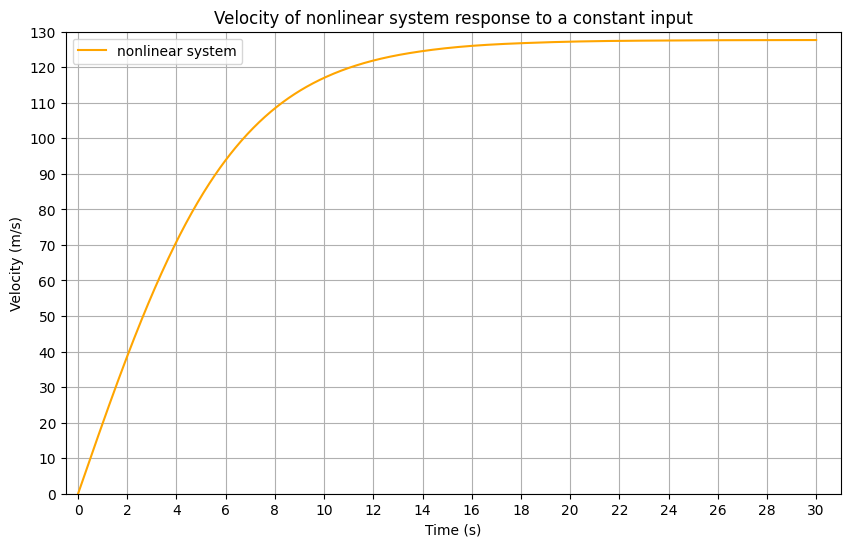

In [86]:
# Plot the response
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.title('Velocity of nonlinear system response to a constant input')
plt.plot(t_out_1, y_out_1[0], label='nonlinear system', color='orange')
plt.xticks(np.linspace(0, 30, 16))
plt.yticks(np.linspace(0,130,14))
plt.ylim(0,130)
plt.xlim(-0.5,31)
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.show()

### Finding the equilibrium points
You have been tasked in analyzing the cars behaviour when disturbed by gusts of wind on the race track. Due to the quadratic dependence on the wind speed, the drag force will increase dramatically in response to small disturbances. To simplify the problem, you decide to linearize the system around the equilibrium point $(v_{eq}, u_{eq})$, which in this case is the stagnation speed.

You use `ct.find_eqpt()` to find the equilibrium point and use a print statement to show the result.


In [87]:
# Function that finds the equilibrium points
initial_guess = 0.01
u = 20
sys = ct.NonlinearIOSystem(nonlinear_sys, nonlinear_sys_out)
v_eq, u_eq, y_eq = ct.find_eqpt(sys, [initial_guess], [u,], return_y=True)
print("Input acceleration u_eq =", u_eq[0], "m/s^2")
print("Stagnation speed v_eq =", v_eq[0],"m/s")

Input acceleration u_eq = 20 m/s^2
Stagnation speed v_eq = 127.68498827514793 m/s


### Linearizing the system
Linearizing the system around the equilibrium point we found $(v_{eq}, u_{eq})$ using `ct.linearize()`. The system can now be written as a state-space model:

\begin{align*}
\Delta \dot{v}(t) &= A \cdot \Delta v(t) + B \cdot \Delta u(t)\\
\Delta y(t) &= D \cdot \Delta v(t) 
\end{align*}

The $\Delta$'s indicate a deviation from the equilibrium point. Note that we choose this notation because we will look at how small deviations from the equilibrium point will affect the system's behaviour.


In [88]:
# linearize the system
linearized_sys =  ct.linearize(sys,v_eq,u_eq) 

# Evaluate system A matrix
A, B, C, D =  linearized_sys.A , linearized_sys.B, linearized_sys.C, linearized_sys.D

# Print system A matrix
print(A)

[[-0.31327097]]


### Simulating the linearized system

Now that we have the linearized system, we want to use it to predict the behavior of our real nonlinear system. As mentioned before, we model the disturbance as a gust of wind.

The linearized system simply takes the slope of the nonlinear function at that given state point $(v_{eq}, u_{eq})$ and doesn't have an offset. Therefore the calculation with the linearized system will only use the change of the cars speed relative to the air $\Delta v(t)$ and input $\Delta u(t)$.

Assume the car is already at the stagnation speed, at $t=0s$, we have a gust of wind of $1\frac{m}{s}$ as a unit step disturbance, opposing the cars travel direction. 

Below, the function simulates the input-output response of the linearized system with the stated conditions and compute the necessary offset. 

In [97]:
def simulate_linear(linearized_sys: ct.statesp.StateSpace, delta_u: Optional[float], delta_v: Optional[float]) -> Tuple[np.ndarray, np.ndarray]:
    """
    This function simulates the linearized system around the equilibrium point.

    Parameters:
    - ``linearized_sys`` (ct.statesp.StateSpace): The linearized system.
    - ``delta_u`` (float): Change in input (u) from equilibrium.
    - ``delta_v`` (float): Change in input (v) from equilibrium..

    Returns:
    - ``Tuple[np.ndarray, np.ndarray]``: A tuple containing the time and the output values.
    """
    
    t = np.linspace(0, 30, 3000)
    t_out_2, delta_y_out_2 = ct.input_output_response(linearized_sys, T=t, U=delta_u, X0=delta_v)
    return t_out_2, delta_y_out_2

t_out_2, delta_y_out_2 = simulate_linear(linearized_sys, 0, 1)
y_out_2 = delta_y_out_2 + v_eq

The next section visualizes the response of the linearized system.

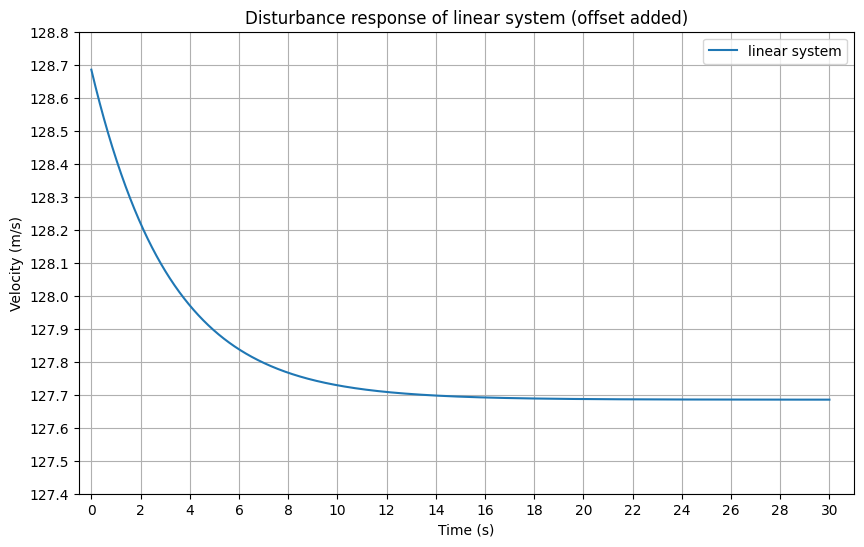

In [90]:
# Plot the response
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.title('Disturbance response of linear system (offset added)')
plt.plot(t_out_2, y_out_2, label='linear system')
plt.xticks(np.linspace(0, 30, 16))
plt.yticks(np.linspace(127,129,21))
plt.ylim(127.4,128.8)
plt.xlim(-0.5,31)
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.show()

In the next section we compare the nonlinear and linear system response side by side (offset added). Does the linearized system predict the behavior of the nonlinear system well around the linearized point?

Feel free to try some different values for $\Delta v(t)$ and input $\Delta u(t)$. In which region around the equilibrium point. Is the linearization a good approximation?

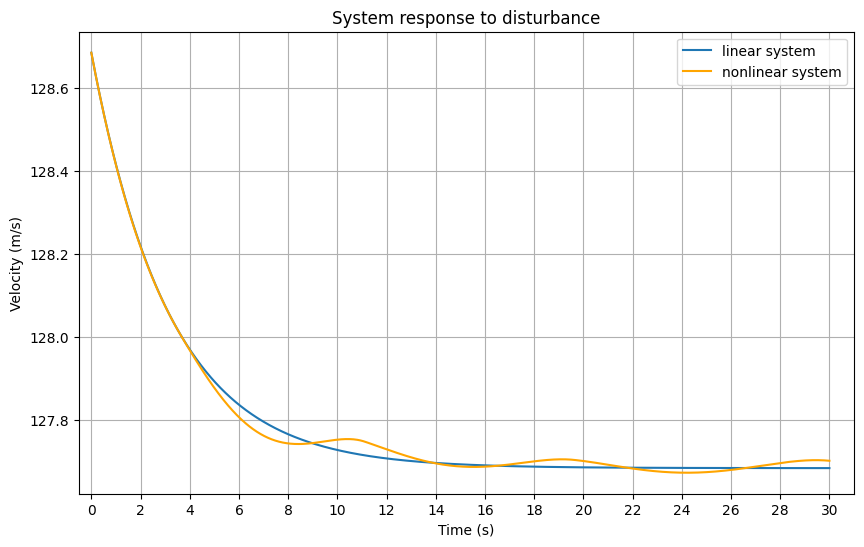

In [104]:
# Non-linear system
# Input: u = 20m/s
# Initial Condition: v = v_eq + 1 m/s
t_NL, y_NL = simulate_nonlinear(nonlinear_sys,nonlinear_sys_out, 20, v_eq+1)

# Linearized system
# Difference to equilibrium input: delta_u = 0
# Difference to equilibrium speed: delta_v = 1 m/s
t_lin, y_lin = simulate_linear(linearized_sys, 0, 1)
y_lin += v_eq

# Plot the response
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.title('System response to disturbance')
plt.plot(t_lin, y_lin, label='linear system')
plt.plot(t_NL, y_NL[0], label='nonlinear system', color='orange')
plt.xticks(np.linspace(0, 30, 16))
plt.xlim(-0.5,31)
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.show()

We can conclude that in close proximity to the equilibrium point around which we linearized, the linearization is a good approximation of the real, nonlinear system. The farther away we go from this point, the worse the approximation becomes. This shows us, that only in a small area of operation linear control theory can be applied.  

## Example 2: Lyapunov Stability

Consider again the nonlinear system described by the differential equation:

$$ \dot{v} = -\gamma v^2 + u $$

where $ \gamma $ is a positive constant and $ u $ is the control input.

As you recall from the previous example we have our equilibrium at $ u_{eq} = 20 \frac{m}{s^2} $ and $ v_{eq} = 127.685 \frac{m}{s} $.

In [92]:
# Initializing the parameters
u_eq = 20
v_eq = 127.685
gamma = 1.293 * 1.1 * 1.38 * 1 / (2 * 800)

###  Lyapunov function $V$

Define a Lyapunov function `V` for the system. A common choice for a Lyapunov function for such systems is a quadratic function. Assume:

$$ V(v) = \frac{1}{2}(v - v_{eq})^2. $$

Additionaly, we define a second function `V_dot` that determines the time derivative of said Lyapunov function.

(The output from our system is also exactly the state:  $y_{eq} = v_{eq}$)

In [93]:
# Define the Lyapunov function
def V(v: float, v_eq: float) -> float:
    return 0.5 * (v - v_eq)**2
# Compute the time derivative of the Lyapunov function
def V_dot(v: float, gamma: float, u: float, y_eq: float) -> float:
    return (v - y_eq) * (-gamma * v**2 + u)

### Stability Analysis

Below you find code that creates values for this analysis and plots them for visual understanding.

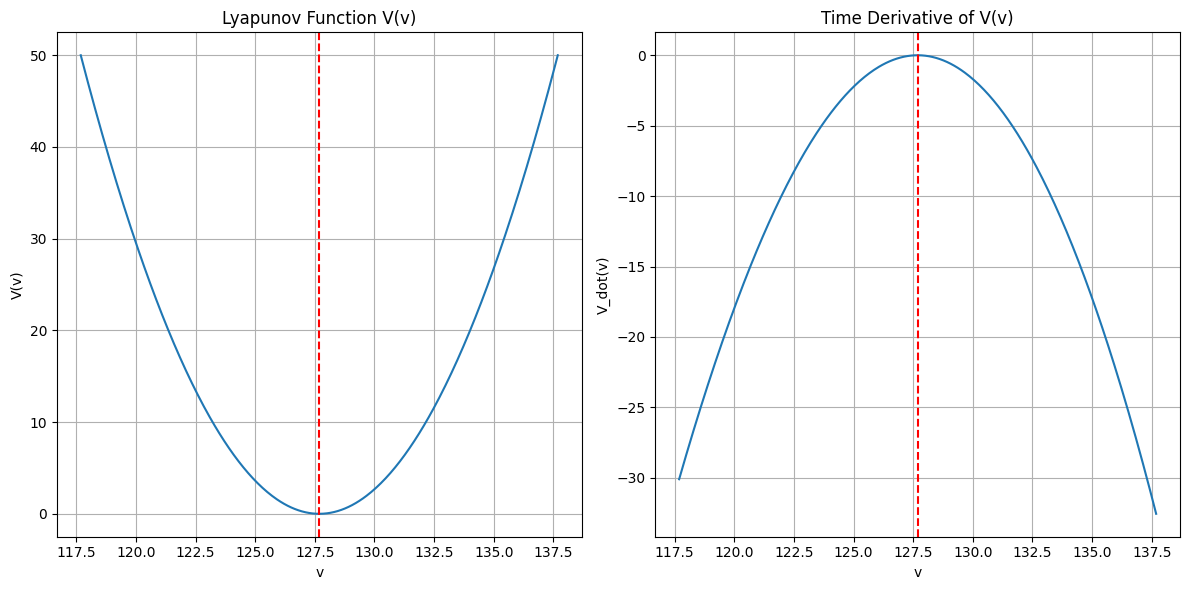

In [94]:
# Values for v to analyze

v_values = np.linspace(v_eq - 10, v_eq + 10, 400)
V_values = V(v_values, v_eq)
V_dot_values = V_dot(v_values, gamma, u_eq, v_eq)

# Plot the Lyapunov function and its derivative
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(v_values, V_values)
plt.axvline(x=v_eq, color='r', linestyle='--')
plt.title('Lyapunov Function V(v)')
plt.xlabel('v')
plt.ylabel('V(v)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(v_values, V_dot_values)
plt.axvline(x=v_eq, color='r', linestyle='--')
plt.title('Time Derivative of V(v)')
plt.xlabel('v')
plt.ylabel('V_dot(v)')
plt.grid(True)

plt.tight_layout()
plt.show()

### Stability
Below we show that $ \dot{V}(v) $ is non-positive definite, using an if-else statment and the stability of the equilibrium point $ y_{eq} $.


In [101]:
# Stability analysis
if np.all(V_dot_values <= 0):
    print("The equilibrium point is stable in the sense of Lyapunov.")
else:
    print("The equilibrium point is not stable in the sense of Lyapunov.")

The equilibrium point is stable in the sense of Lyapunov.


#### Conclusion

If $ \dot{V}(v) \leq 0 $ for all $ v $, it implies that $ V(v) $ is non-increasing along the system's trajectories. This means any small deviation from $ v_{eq} $ will not cause the system to diverge away from $ v_{eq} $. Thus, the equilibrium point $ v_{eq} $ is stable in the sense of Lyapunov.

### Global stability

Remember the conditions from your lecture for global stability:

* $ V(x) \geq 0 $, for all $ x \in D $.
* $ V(x) = 0 \iff x = x_0 $, i.e., $ V(x) = 0 $ if and only if $ x = x_0 $.
* $ \lim_{|x| \to +\infty} V(x) = +\infty $.
* $ \frac{d}{dt} V(x(t)) = \frac{\partial V(x)}{\partial x} \cdot \frac{dx(t)}{dt} = \frac{\partial V(x)}{\partial x} \cdot f(x) \leq 0 $, for all $ x(t) \in \mathbb{R}^n $.

Consider these conditions and discuss whether the chosen Lyapunov function $ V(v) = \frac{1}{2}(v - v_{eq})^2 $ satisfies them for global stability of the system.

#### Conclusion

By looking at the plots and the Lyapunov function itself one can see that our system satisfies global stability for our chosen equilibrium point.